In [16]:
import torch
import torch.nn as nn
import torch.utils.data
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import sys
sys.path.append("../")
# import x3x3.frozen as frozen

data = np.load("mnist27x27.npy")

# Batch size, channels, height, width

# train on 3 x 3
class SupervisedConvNet(nn.Module):
    def __init__(self, filter_size, square_size, hidden_size, num_hidden_layers, center,
                first_activation = "tanh", activation_func = "sigmoid",
                out_channels = 1):
        """
        Arguments:
        filter_size ~ size of the convolution kernel (3 x 3)
        square size ~ how many strides of convolution in the input
        """
        super(SupervisedConvNet, self).__init__()
        self.filter_size = filter_size
        self.square_size = square_size
        self.hidden_size = hidden_size
        self.out_channels = out_channels
        if first_activation == "tanh":
            self.first_activation = torch.tanh
        elif first_activation == "relu":
            self.first_activation = torch.nn.LeakyReLU(0.1)
        if activation_func == "sigmoid":
            self.activation_func = torch.sigmoid
        elif activation_func == "relu":
            self.activation_func = torch.nn.LeakyReLU(0.1)

        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        # parameters
        param = {}
        if center == "keep":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/9
            param['conv2d.bias'] = torch.tensor([0.0])
            self.conv1.bias = torch.nn.Parameter(param['conv2d.bias'], requires_grad=False)
        elif center == "omit":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 0.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/8
            # param['conv2d.bias'] = torch.tensor([0.0])
        elif center == "pre_trained_81x81":
            param['conv2d.weight'] = torch.tensor([[[[-0.0900, -0.0407, -0.0965],
          [-0.0413, -0.0011, -0.0363],
          [-0.0906, -0.0344, -0.0908]]]])
            param['conv2d.bias'] = torch.tensor([-0.0345])
            self.conv1.bias = torch.nn.Parameter(param['conv2d.bias'], requires_grad=False)
        elif center == "pre_trained_27x27":
            param['conv2d.weight'] = -torch.tensor([[[[-0.3833, -0.0056, -0.4275],
          [-0.0172,  0.1212, -0.0063],
          [-0.4010, -0.0461, -0.3762]]]])
            param['conv2d.bias'] = -torch.tensor([-0.0690])
            self.conv1.bias = torch.nn.Parameter(param['conv2d.bias'], requires_grad=False)
        self.conv1.weight = torch.nn.Parameter(param['conv2d.weight'], requires_grad=False)


        self.first_linear = nn.Linear(self.out_channels * square_size ** 2, hidden_size)
        hidden_layer = [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        self.linear_hidden = nn.ModuleList(hidden_layer)
        self.linear_output = nn.Linear(hidden_size, 1)



    def forward(self, x):
        x = self.first_activation(self.conv1(x))#.view(-1, 1, self.out_channels * self.square_size**2)
#         x = self.activation_func(self.first_linear(x))
#         for linear in self.linear_hidden:
#             x = self.activation_func(linear(x))
#         x = torch.sigmoid(self.linear_output(x))
#         x = x.squeeze(1)

        return x


def coarse_grain_frozen_conv(correlated_data = data):
    run_mode = "frozen_convolution_pretrained_relu"
    mode = "run"
    if mode == "run":
        hidden_size = 10
        out_channels = 1
        num_hidden_layers = 1


        if run_mode == "frozen_convolution_pretrained_relu":
            """
            """
            run_num = 1
            filename = f"frozen_convolution_pretrained_relu_{run_num}.pl"
            out_channels = 1
            try:
                with open(filename, "rb") as handle:
                    results = pickle.load(handle)
            except:
                results = []
            results = []
            model = SupervisedConvNet(filter_size = 3, square_size = 9, \
                    hidden_size = hidden_size, out_channels = out_channels,
                    center = "pre_trained_27x27", first_activation = "tanh",
                    activation_func = "relu", num_hidden_layers = num_hidden_layers)
            data = torch.tensor(correlated_data).unsqueeze(1).type('torch.FloatTensor')
            out = model(data)

    return out


In [10]:
out = coarse_grain_frozen_conv()


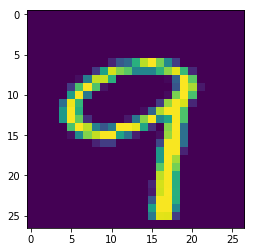

In [17]:
np.set_printoptions(precision=1)
import matplotlib.pyplot as plt
plt.imshow(data[0, 0, :27, :27])
plt.show()

In [13]:
torch.set_printoptions(precision=1)
out[1]

tensor([[[ 0.5,  0.3,  0.4,  0.6,  0.4,  0.1, -0.3,  0.3,  0.6],
         [ 0.5,  0.5,  0.4,  0.5,  0.1,  0.5, -0.4,  0.1,  0.6],
         [ 0.5,  0.6,  0.3,  0.6,  0.6,  0.5, -0.5, -0.6,  0.5],
         [ 0.4,  0.5,  0.6,  0.5,  0.1, -0.2, -0.2,  0.1,  0.5],
         [ 0.6,  0.4,  0.6,  0.6,  0.1, -0.3,  0.3,  0.6,  0.5],
         [ 0.6,  0.6,  0.6,  0.6,  0.4,  0.1,  0.6,  0.6,  0.6],
         [ 0.3,  0.3,  0.2,  0.5, -0.2, -0.1,  0.4,  0.6,  0.6],
         [ 0.6,  0.4,  0.3,  0.4,  0.5,  0.3,  0.5, -0.1,  0.3],
         [ 0.6,  0.2,  0.6,  0.6,  0.6,  0.4,  0.0, -0.3,  0.2]]])

In [14]:
# torch.set_printoptions(precision=1)
out.shape

torch.Size([10000, 1, 9, 9])

In [18]:
data.shape

(60000, 1, 27, 27)

In [20]:
np.random.permutation(81).reshape(9, 9)

array([[50, 64, 35, 41, 71, 28, 75,  0, 58],
       [18, 17,  1, 70, 66, 67, 34, 19,  3],
       [55, 30, 65, 74, 21, 72, 53, 52, 10],
       [ 5, 60, 45, 37, 15, 16, 44, 51, 13],
       [14, 26, 61, 23, 80, 22, 12, 77, 59],
       [43, 68,  2, 63, 48, 31, 36, 56, 69],
       [57, 27, 40, 20, 73, 76, 25, 29, 47],
       [ 9, 38,  6,  7,  4, 49, 33, 79, 42],
       [62, 11, 78, 39, 46,  8, 32, 24, 54]])

In [42]:
def generate_uncorrelated_data(data, expected_shape = 27):
    # data expects an array of shape [10000, expected_shape, expected_shape]
    expected_shape = int(expected_shape / 3)
    uncorrelated_data = []
    for _ in range(10000):
        d = data[_]
        permute = np.random.permutation(expected_shape ** 2).reshape(expected_shape, expected_shape)
        uncorrelated = []
        for i in range(expected_shape):
            tile = []
            for j in range(expected_shape):
                square = permute[i, j]
                vertical = square % expected_shape
                horizontal = square // expected_shape
                tile.append(d[horizontal:(horizontal + 3), vertical:(vertical + 3)])
            uncorrelated.append(np.hstack(tile))
        uncorrelated_data.append(np.vstack(uncorrelated))

    uncorrelated_data = np.array(uncorrelated_data)
    return uncorrelated_data

uncorrelated_data = generate_uncorrelated_data(torch.tensor(data).squeeze(1).numpy())
uncorrelated_data.shape

(10000, 27, 27)

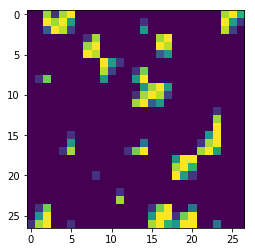

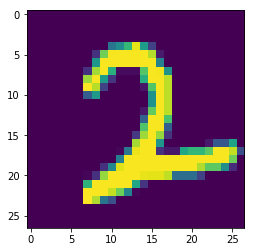

In [44]:
plt.imshow(uncorrelated_data[10])
plt.show()
plt.imshow(data[10, 0])
plt.show()

In [ ]:
out.shape

In [49]:
# save files
np.save("mnist27x27.npy", data.squeeze(1))
np.save("mnist27x27_uncorrelated.npy", uncorrelated_data)

In [28]:
out.squeeze(1).numpy()[0]

array([[ 0.1,  0.5,  0.5,  0.6,  0.6,  0.6,  0.6,  0.6,  0.4],
       [ 0.3,  0.3,  0.3,  0.6,  0.6,  0.6,  0.6,  0.5,  0.6],
       [ 0.5,  0.6,  0.6,  0.6,  0.5,  0.5,  0.2,  0.2,  0.5],
       [ 0.6,  0.5,  0.6,  0.6,  0.6,  0.6,  0.4, -0.1,  0.5],
       [ 0.6,  0.5,  0.6,  0.6,  0.5,  0.6,  0.5,  0.1,  0.1],
       [ 0.6,  0.6,  0.6,  0.5,  0.4,  0.5,  0.6,  0.2,  0.4],
       [ 0.6,  0.5,  0.5,  0.5,  0.6,  0.6,  0.6,  0.5,  0.6],
       [ 0.6,  0.6,  0.5,  0.6,  0.6,  0.6,  0.6, -0. ,  0.3],
       [ 0.3,  0.3,  0.3,  0.2,  0.6,  0.6,  0.6,  0.6,  0.1]],
      dtype=float32)

In [30]:
uncorrelated_data[10]

array([[ 0.3,  0.5,  0.4, -0.2,  0.2,  0.5, -0.2,  0.2,  0.3],
       [ 0.2,  0.2,  0.5, -0.4, -0.1, -0.1,  0.5,  0.2,  0.5],
       [ 0.5,  0.6,  0.5, -0.6, -0.2, -0.1,  0.4,  0.4,  0.5],
       [ 0.6,  0. , -0. , -0.6, -0.2, -0.2,  0.6,  0.1,  0.4],
       [ 0.4, -0.2,  0.1, -0.4, -0.2, -0.4,  0.3,  0.5,  0.6],
       [ 0. , -0. ,  0.3, -0.4, -0.2, -0.4,  0.6,  0.4,  0.6],
       [-0.5, -0.5, -0.5,  0.5,  0.7,  0.5,  0.4,  0.4, -0.4],
       [-0.3, -0.6, -0.4,  0.2,  0.6,  0.5,  0.5,  0.5, -0.2],
       [-0.5, -0.6, -0.5,  0.5,  0.6, -0.2,  0.3,  0.2,  0.5]],
      dtype=float32)

In [45]:
uncorrelated_data.shape

(10000, 27, 27)

In [48]:
data.squeeze(1).shape

(60000, 27, 27)